# Imports

In [31]:
import tensorflow as tf
from keras import backend as K
from keras import layers, models
from keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import cv2
import mediapipe as mp
from PIL import Image
import os
from random import shuffle
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import random
import tkinter as tk
from pathlib import Path
from tensorflow.keras.utils import plot_model  # Importa la funzione plot_model da keras.utils.vis_utils

# DataSet

## Caricamento

In [3]:
# Carica il dataset
file = pd.read_csv('DataSet\A_Z Handwritten Data.csv')
# Separa le features (X) e le etichette (y)
X = file.iloc[:, 1:]
y = file.iloc[:, 0]

# Dividi i dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sovracampionamento delle classi minoritarie sul set di addestramento
#print("Sovracampionamento delle classi minoritarie")
#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)
# Normalizza i dati
standard_scaler = MinMaxScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)


# Reshape dei dati in modo da adattarli alla forma richiesta dai modelli CNN
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Codifica one-hot delle etichette
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


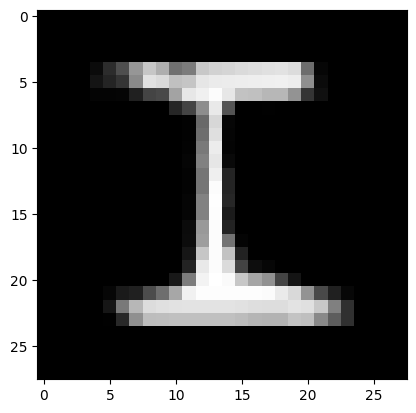

In [27]:
f=X[y == 8]
random_int = random.randint(0, f.shape[0])
plt.imshow(f.iloc[random_int].values.reshape(28, 28), cmap='gray')

## Studio

C:\Users\oligi\AppData\Local\Temp\ipykernel_23704\3917900352.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=label_size, x=class_labels, palette=colors_from_values(label_size, "YlOrRd"))
C:\Users\oligi\AppData\Local\Temp\ipykernel_23704\3917900352.py:24: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(y=label_size, x=class_labels, palette=colors_from_values(label_size, "YlOrRd"))
C:\Users\oligi\AppData\Local\Temp\ipykernel_23704\3917900352.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=resampled_class_distribution.values, x=class_labels, palette=colors_from_values(label_si

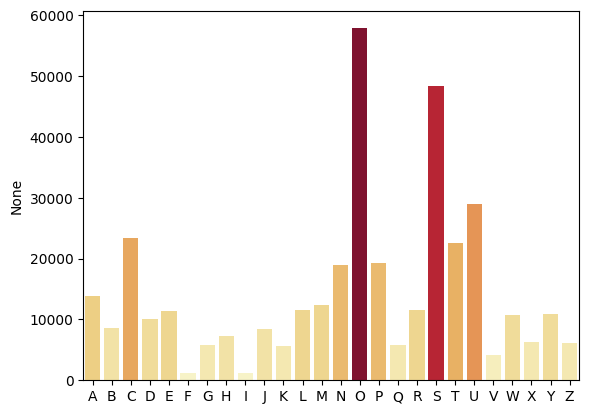

{0: 0.017281294445071777, 1: 0.02765046984987315, 2: 0.010238552379798389, 3: 0.02365051042615951, 4: 0.020950548309326966, 5: 0.2060827795861569, 6: 0.041595673838719274, 7: 0.03320508072301198, 8: 0.21399488630241115, 9: 0.028220213429730422, 10: 0.04277606151324299, 11: 0.020686541745097573, 12: 0.019428848302423838, 13: 0.012607799719026853, 14: 0.004144820971183753, 15: 0.012392031056238068, 16: 0.04123783080844812, 17: 0.02072231304329072, 18: 0.004950004598581145, 19: 0.010654557575403444, 20: 0.008262350822486917, 21: 0.05731092124789586, 22: 0.022224988191645076, 23: 0.038213372554001986, 24: 0.022071486569546044, 25: 0.03944606199122786}


In [3]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'} 
dataset_alphabets = file.copy()
dataset_alphabets.rename(columns={'0':'label'}, inplace=True)
dataset_alphabets['label'] = dataset_alphabets['label'].map(alphabets_mapper)
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                'U', 'V', 'W', 'X', 'Y', 'Z']
dataset_alphabets = dataset_alphabets.groupby('label')
label_size=dataset_alphabets.size()
# Calcola la nuova distribuzione delle classi dopo il sovracampionamento
y_bo=np.argmax(y_train, axis=1)
resampled_class_distribution = pd.Series(y_bo).value_counts().sort_index()
#label_size=label_size.sort_index(ascending=False)
my_palette = sns.color_palette("coolwarm", len(label_size))
sns.barplot(y=label_size, x=class_labels, palette=colors_from_values(label_size, "YlOrRd"))
sns.barplot(y=resampled_class_distribution.values, x=class_labels, palette=colors_from_values(label_size, "YlOrRd"))
#label_size.plot.barh(figsize=(10,10), color=my_palette)
plt.show()
# Calcola il peso di ciascuna lettera
class_weights = {}
for letter, frequency in label_size.items():
    class_weights[ord(letter)-ord('A')] = 1 / frequency

# Normalizza i pesi
total_weight = sum(class_weights.values())
for letter, weight in class_weights.items():
  class_weights[letter] = weight / total_weight

# Stampa i pesi di classe
print(class_weights)



# Modello

## Struttura

In [4]:
model = models.Sequential()

# Primo strato convoluzionale
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Secondo strato convoluzionale
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flattening
model.add(layers.Flatten())

# Primo strato completamente connesso
model.add(layers.Dense(128, activation='relu'))

# Strato di output
model.add(layers.Dense(26, activation='softmax'))

model.summary()

c:\Users\oligi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,098 (887.10 KB)

 Trainable params: 227,098 (887.10 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)

## Addestramento

In [6]:
from pathlib import Path
from time import strftime

def get_log(root="ASCII/Logs"):
    return Path(root) / strftime("run %Y-%m-%d %H-%M-%S")
run_log=get_log()
tensorboard=tf.keras.callbacks.TensorBoard(run_log,profile_batch=(100,200))

In [7]:
epoche=10
numero_batch=256
#training
# Training
# Addestramento del modello usando il generatore di immagini con data augmentation
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoche, batch_size=numero_batch,callbacks=[tensorboard])

Epoch 1/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.8606 - loss: 0.5038 - val_accuracy: 0.9757 - val_loss: 0.0883
Epoch 2/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 45s 38ms/step - accuracy: 0.9789 - loss: 0.0756 - val_accuracy: 0.9814 - val_loss: 0.0672
Epoch 3/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 45s 38ms/step - accuracy: 0.9849 - loss: 0.0536 - val_accuracy: 0.9855 - val_loss: 0.0520
Epoch 4/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.9883 - loss: 0.0412 - val_accuracy: 0.9869 - val_loss: 0.0487
Epoch 5/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.9903 - loss: 0.0333 - val_accuracy: 0.9885 - val_loss: 0.0430
Epoch 6/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.9925 - loss: 0.0249 - val_accuracy: 0.9902 - val_loss: 0.0375
Epoch 7/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.9936 - loss: 0.0203 - val_accuracy: 0.9901 - val_loss: 0.0360
Epoch 8/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 44s 38ms/step - accuracy: 0.9946 -

# Studi Post Addestramento

In [8]:
%load_ext tensorboard
print(run_log)
%tensorboard --logdir=./ASCII/Logs

ASCII\Logs\run 2024-06-06 12-51-16


Launching TensorBoard...

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9922 - loss: 0.0301
Test accuracy: 0.9925224781036377
Test loss: 0.02932744473218918


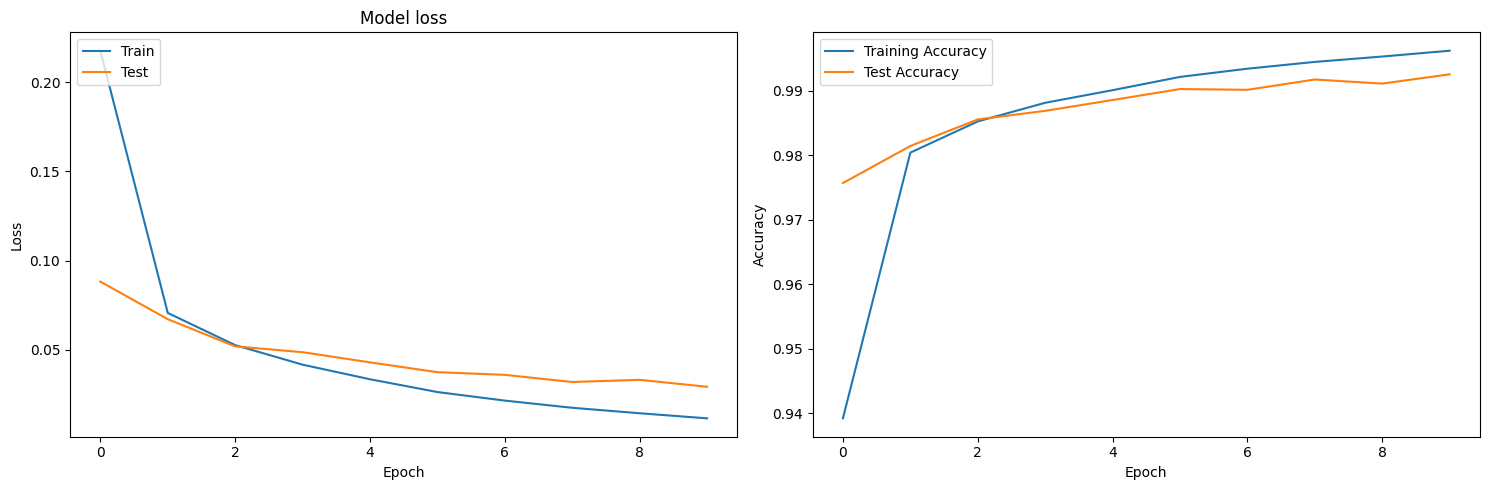

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Plot della Loss e dell'Accuracy
plt.figure(figsize=(15, 5))

# Plot della Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot dell'Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
#plt.plot(range(epoche), [test_acc] * epoche, label='Test Accuracy', linestyle='--', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Salva il modello
model.save('ASCII_model.h5')


## Predizioni

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step


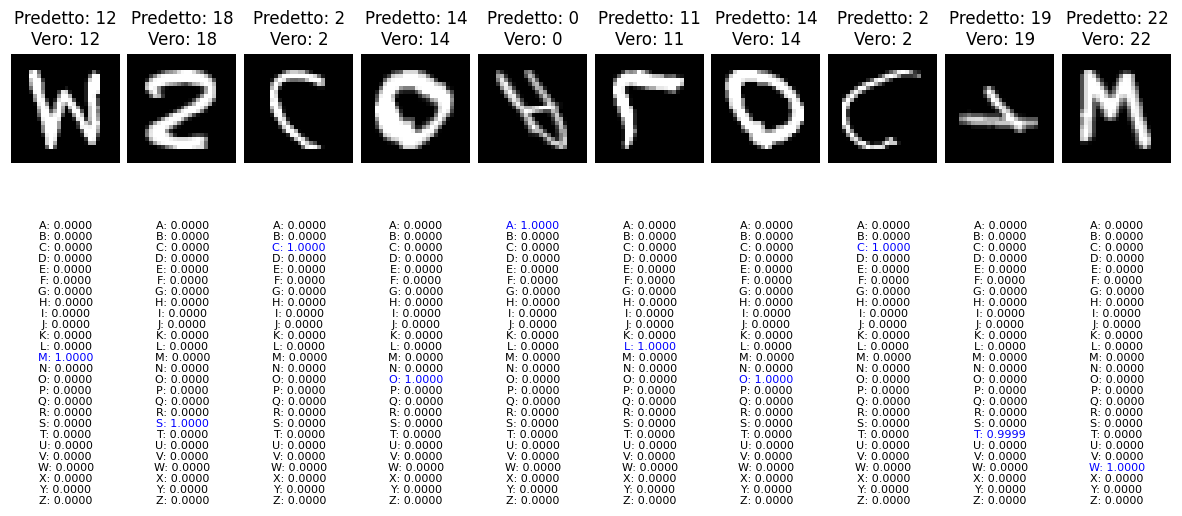

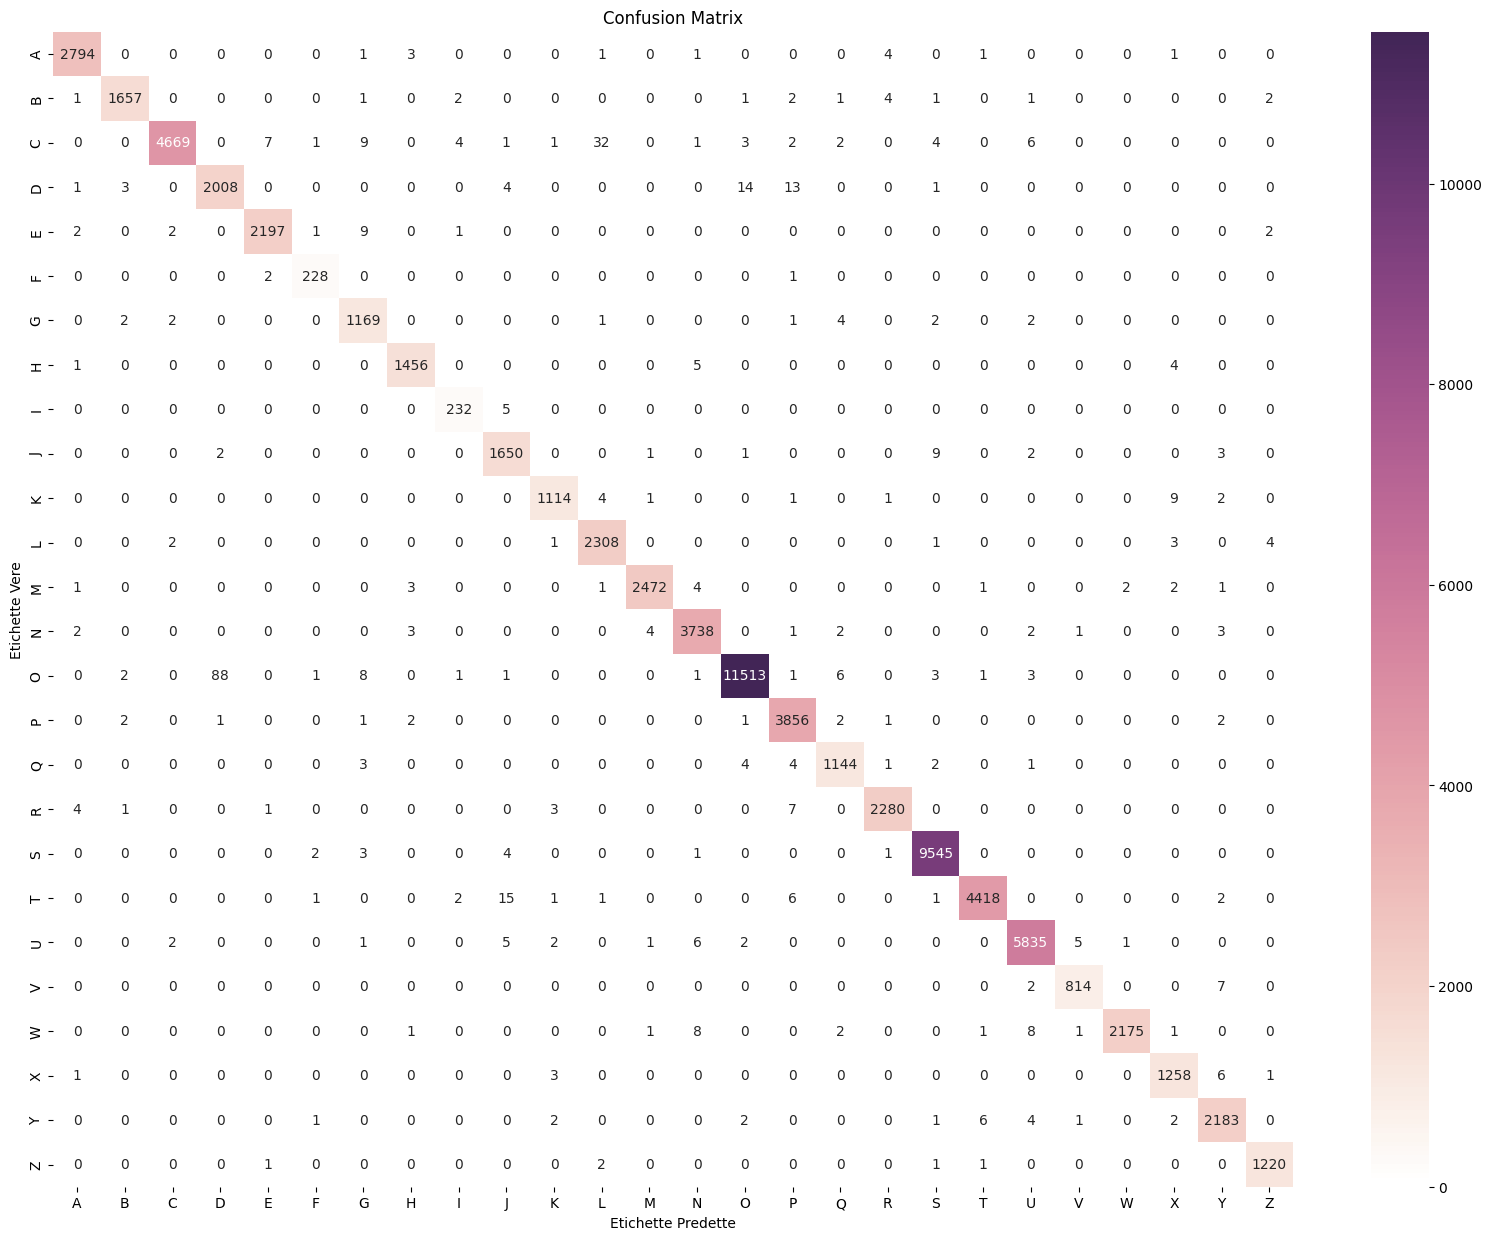

In [10]:
def plot_predictions_with_probabilities(model, X_test_reshaped, y_test_categorical):
    # Genera le predizioni
    predictions = model.predict(X_test_reshaped)
    predicted_labels = np.argmax(predictions, axis=1)
    y_test_true_labels = np.argmax(y_test_categorical, axis=1)  # Etichette vere

    # Dimensioni dell'immagine
    img_height, img_width = 28, 28
    figsize_height, figsize_width = 3, 15
    tot = 10

    # Crea una figura
    fig, axes = plt.subplots(nrows=2, ncols=tot, figsize=(figsize_width, figsize_height))
    fig.subplots_adjust(wspace=0.05, hspace=0.1)

    # Itera sulle predizioni
    for i in range(tot):
        # Visualizza l'immagine e imposta le dimensioni
        axes[0, i].imshow(np.squeeze(X_test_reshaped[i]), cmap='gray')
        axes[0, i].set_title(f'Predetto: {np.argmax(predictions[i])}\nVero: {y_test_true_labels[i]}')
        axes[0, i].axis('off')

        # Stampa le probabilità per ciascuna classe
        probabilities = predictions[i]
        for j in range(len(probabilities)):
            color = 'black'
            if j == y_test_true_labels[i]:
                color = 'blue'  # Colora in blu la classe vera
            elif j == np.argmax(probabilities):
                color = 'red'  # Colora in rosso la probabilità massima predetta

            axes[1, i].text(0.5, 0.5 - j * 0.1, f"{chr(65 + j)}: {probabilities[j]:.4f}",
                            transform=axes[1, i].transData,
                            color=color,
                            fontsize=8, ha='center', bbox={'facecolor': 'white', 'edgecolor': 'white', 'pad': 0})

        # Imposta le dimensioni delle celle
        axes[0, i].set_aspect('equal', adjustable='box')
        axes[0, i].set_xlim([0, img_width])
        axes[0, i].set_ylim([0, img_height])

        # Rimuovi gli assi per la cella della probabilità
        axes[1, i].axis('off')

    # Rimuovi gli assi per tutte le celle
    for ax in axes.flat:
        ax.axis('off')
        
    class_labels = [chr(65 + i) for i in range(26)]  # Genera le etichette delle classi (A-Z)

    # Mostra la figura
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test_true_labels, predicted_labels)
    m = 2.5
    cmap = sns.cubehelix_palette(light=1, as_cmap=True, hue=1, dark=0.2)
    plt.figure(figsize=(8 * m, 6 * m))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Etichette Predette')
    plt.ylabel('Etichette Vere')
    plt.title('Confusion Matrix')
    plt.show()

# Esegui il codice
plot_predictions_with_probabilities(model,  X_test, y_test)

# Interfaccia Da Telecamera e Riconoscimento delle Lettere

In [34]:
# Load model if not already loaded
if not ('model' in locals() or 'model' in globals()):
    print("Caricamento del modello")
    model = tf.keras.models.load_model('ASCII_model.h5')
plot_model(model,show_shapes=True,show_layer_names=False,show_layer_activations=True,to_file=Path(r"C:\Uni\Mypython\MachineLearning\ASCII\StrutturaRete.png"))

def leggi_numeroimmagine():
    try:
        df = pd.read_json("config.json", orient="records", lines=True)
        numeroimmagine = df["numeroimmagine"].iloc[0]
    except (FileNotFoundError, pd.errors.EmptyDataError, IndexError):
        numeroimmagine = 0
    return numeroimmagine

def estrai_parte_disegnata(imagecanvas):
    gray = cv2.cvtColor(imagecanvas, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(np.vstack(contours))
        bordo = 20
        if h > w:
            offset = (h - w) // 2
            drawn_part = imagecanvas[y-bordo:y+h+bordo, x-bordo-offset:x+w+bordo+offset]
        else:
            offset = (w - h) // 2
            drawn_part = imagecanvas[y-bordo-offset:y+h+bordo+offset, x-bordo:x+w+bordo]
    else:
        drawn_part = np.zeros_like(imagecanvas)

    return drawn_part

def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    width = root.winfo_screenwidth()
    height = root.winfo_screenheight()
    return width, height

def cam(full_screen=False, resolution=(640, 480),infoaggiuntive=False):
    if full_screen:
        resolution = get_screen_resolution()
    
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, resolution[0])
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, resolution[1])
    
    success, img = cap.read()
    if not success:
        print("Failed to capture image from webcam.")
        return

    width, height = resolution
    imagecanvas = np.zeros((height, width, 3), dtype="uint8")
    numeroimmagine = leggi_numeroimmagine()
    x1, y1 = 0, 0
    punte = [4, 8, 12, 16, 20]
    iniziodita = [1, 5, 9, 13, 17]
    detector = mp.solutions.hands
    hands = detector.Hands(max_num_hands=1)
    mpDraw = mp.solutions.drawing_utils

    if full_screen:
        cv2.namedWindow("Combined", cv2.WND_PROP_FULLSCREEN)
        cv2.setWindowProperty("Combined", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

    while cap.isOpened():
        success, img = cap.read()
        if not success:
            break
        img = cv2.flip(img, 1)
        img = cv2.resize(img, (width, height))  # Resize the captured frame to match the desired resolution
        results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        combined_image = cv2.addWeighted(img, 0.7, imagecanvas, 0.3, 0)
        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:
                mpDraw.draw_landmarks(img, handLms, detector.HAND_CONNECTIONS)
                landmarks = handLms.landmark
                posizione = dita_alzate(punte, iniziodita, landmarks)
                if posizione == [1, 1, 0, 0, 0]:
                    cv2.putText(combined_image, "draw mode", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    x, y = int(landmarks[8].x * imagecanvas.shape[1]), int(landmarks[8].y * imagecanvas.shape[0])

                    if x1 == 0 and y1 == 0:
                        x1, y1 = x, y

                    cv2.line(img, (x, y), (x1, y1), (255, 255, 255), 10)
                    cv2.line(imagecanvas, (x, y), (x1, y1), (255, 255, 255), 10)
                    x1, y1 = x, y
                else:
                    x1, y1 = 0, 0

                if posizione == [1, 1, 1, 1, 1]:
                    drawn_part = estrai_parte_disegnata(imagecanvas)
                    if np.count_nonzero(drawn_part) != 0:
                        cv2.imwrite(f"Immagini/parte_disegnata{numeroimmagine}.png", drawn_part)
                        numeroimmagine += 1
                        imagecanvas = np.zeros((height, width, 3), dtype="uint8")

                for id, lm in enumerate(handLms.landmark):
                    h, w, c = img.shape
                    cx, cy = int(lm.x * w), int(lm.y * h)

                    if id == 0:
                        cv2.circle(img, (cx, cy), 15, (255, 0, 255), cv2.FILLED)

        if np.count_nonzero(imagecanvas) > 0:
            immage = estrai_parte_disegnata(imagecanvas)
            immage = Image.fromarray(immage)
            immage = immage.convert('L')
            immage = immage.resize((28, 28))
            dati_immagine = np.array(immage) / 255.0

            dati_immagine_normalizzati = np.expand_dims(dati_immagine, axis=(0, 3))
            predizioni = model.predict(dati_immagine_normalizzati)

            for classe in predizioni:
                probabilita_classi = list(enumerate(classe))
                probabilita_classi.sort(key=lambda x: x[1], reverse=True)

                print("Probabilità per ogni classe (in ordine decrescente):")
                for i, (indice_classe, probabilita) in enumerate(probabilita_classi):
                    print(f"Classe {chr(65 + indice_classe)}: {probabilita}")

            classe_predetta = chr(65 + np.argmax(predizioni))
            print(f"Classe predetta: {classe_predetta}")
            if classe_predetta:
                cv2.putText(combined_image, f"Classe predetta: {classe_predetta}", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        cv2.imshow("Combined", combined_image)
        if infoaggiuntive:
            cv2.imshow("Image", img)
            cv2.imshow("Canvas", imagecanvas)
        key = cv2.waitKey(1)

        if key == ord('q') or key == 27:
            break

    cap.release()
    cv2.destroyAllWindows()
    df = pd.DataFrame({"numeroimmagine": [numeroimmagine]})
    df.to_json("config.json", orient="records", lines=True)

def dita_alzate(punte, iniziodita, landmarks):
    dita = []
    for i in range(5):
        if landmarks[0]:
            if i != 0:
                punto0, punto1 = float(landmarks[0].y), float(landmarks[iniziodita[i]].y)
                if not min(punto0, punto1) < landmarks[punte[i]].y < max(punto0, punto1):
                    dita.append(1)
                else:
                    dita.append(0)
            else:
                scala=10000
                x1,y1,z1=landmarks[punte[0]].x,landmarks[punte[0]].y,landmarks[punte[0]].z
                x2,y2,z2=landmarks[13].x,landmarks[13].y,landmarks[13].z
                punto0, punto1 = np.array([x1,y1,z1])*scala, np.array([x2,y2,z2])*scala
                dist = np.linalg.norm(punto0 - punto1)
                if dist>1400:
                    dita.append(1)
                else:
                    dita.append(0)
    return dita

# Call the function with full_screen as True or False
#info aggiuntive per vedere i vari passaggi
cam(full_screen=True,infoaggiuntive=False)  # For full-screen mode
# cam(full_screen=False)  # For normal window mode

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Probabilità per ogni classe (in ordine decrescente):
Classe P: 0.7821932435035706
Classe O: 0.14682579040527344
Classe N: 0.036898210644721985
Classe R: 0.01612187549471855
Classe C: 0.0070094880647957325
Classe D: 0.005983823444694281
Classe T: 0.0009857761906459928
Classe J: 0.0009439654531888664
Classe Y: 0.0007602812838740647
Classe V: 0.0005758998449891806
Classe S: 0.00050227070460096
Classe G: 0.0003069962840527296
Classe F: 0.00030644258367829025
Classe A: 0.00017820444190874696
Classe B: 0.00016218503878917545
Classe M: 0.00012449825590010732
Classe H: 3.723637928487733e-05
Classe E: 3.2949799788184464e-05
Classe K: 2.7042699002777226e-05
Classe U: 1.5574776625726372e-05
Classe W: 4.0622958294989076e-06
Classe X: 2.154999265258084e-06
Classe Q: 1.3231489219833747e-06
Classe I: 4.822708206120296e-07
Classe Z: 2.451093052968645e-07
Classe L: 3.4129815418282305e-08
Classe predetta: P
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Probabilità per ogni 

Inserisci il numero dell'immagine da predire: 
Numero immagine: 124


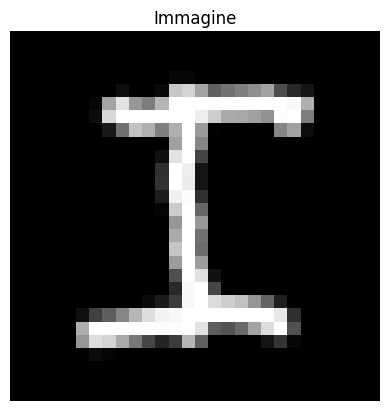

Caricamento del modello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Probabilità per ogni classe (in ordine decrescente):
Classe I: 1.0
Classe J: 2.7373966204891076e-08
Classe L: 1.6425741877768019e-09
Classe X: 6.810712584182088e-12
Classe Z: 1.4617446792916655e-12
Classe T: 6.240353286196543e-13
Classe U: 2.39217960761387e-13
Classe D: 1.6284708499215983e-13
Classe S: 1.1179376651834771e-13
Classe N: 2.9441346940001526e-15
Classe Y: 9.863346093312033e-16
Classe B: 3.295814462189343e-16
Classe K: 9.352577152834911e-17
Classe E: 6.842021789754408e-17
Classe R: 6.716983844871912e-17
Classe C: 1.782555194897686e-17
Classe G: 1.3057629958662004e-17
Classe O: 3.484176763916499e-19
Classe P: 5.0848230126183776e-20
Classe F: 3.8335136189144544e-20
Classe Q: 8.67226473763412e-22
Classe V: 4.6687770265201214e-23
Classe W: 2.144897655166551e-23
Classe M: 3.2851925043464047e-25
Classe H: 9.02331459014859e-27
Classe A: 3.7892560914847063e-28
Classe predetta: I


In [ ]:
print("Inserisci il numero dell'immagine da predire: ")
numeroimmagine = leggi_numeroimmagine()-1
print(f"Numero immagine: {numeroimmagine}")
# Inserisci il percorso dell'immagine
percorso_immagine = f"Immagini/parte_disegnata{numeroimmagine}.png"
# Carica l'immagine utilizzando la libreria PIL
immagine = Image.open(percorso_immagine).convert('L')  # 'L' indica la modalità scala di grigi

# Ridimensiona l'immagine alle dimensioni attese dal modello (28x28)
immagine = immagine.resize((28, 28))
# Visualizza l'immagine utilizzando matplotlib
plt.imshow(immagine, cmap='gray')
plt.title("Immagine")
plt.axis("off")  # Nasconde gli assi
plt.show()

# Converte l'immagine in un array NumPy e normalizzala
dati_immagine = np.array(immagine) / 255.0

# Aggiungi una dimensione per simulare il batch (1, 28, 28, 1)
dati_immagine_normalizzati = np.expand_dims(dati_immagine, axis=(0, 3))
if not 'model' in locals() or 'model' in globals():
    print("Caricamento del modello")
    model=tf.keras.models.load_model('ASCII_model.h5')
# Effettua le predizioni
predizioni = model.predict(dati_immagine_normalizzati)

for classe in predizioni:
    probabilita_classi = list(enumerate(classe))
    probabilita_classi.sort(key=lambda x: x[1], reverse=True)
    
    print("Probabilità per ogni classe (in ordine decrescente):")
    for i, (indice_classe, probabilita) in enumerate(probabilita_classi):
        print(f"Classe {chr(65 + indice_classe)}: {probabilita}")


# Le predizioni sono nella forma di probabilità per ogni classe, puoi ottenere la classe predetta usando argmax
classe_predetta = chr(65 + np.argmax(predizioni))
print(f"Classe predetta: {classe_predetta}")

# Salva l'immagine predetta nella directory corrispondente
path = f"Immagini_postWork/{classe_predetta}"
elementi = os.listdir(path)
immagine.save(f"{path}/immagine{len(elementi)}.png")
